In [90]:
using Plots; gr();
include("../src/invertData.jl")
include("../src/config.jl")
include("../src/crustDistribution.jl")
using DelimitedFiles
using MAT 
using StatGeochem

["Lower_Vp", "Pd", "MgO", "C", "Nb", "Ag", "Gd", "Middle_Rho", "Age", "Calc_Upper_VpVs", "Sb", "TiO2", "Cs", "Be", "Sr", "Ta", "Ga", "Te", "Eustar", "Al2O3", "CO2", "Freeair", "Y", "Calc_Middle_VpVs", "U", "FeO", "Kv", "Fe2O3", "Elevation", "Au", "MZr", "Ce", "V", "Loc_Prec", "Tsat", "Upper_Vp", "Ff", "Mo", "Pr", "Th", "P2O5", "Zn", "Vs", "Sc", "Max_age", "Age_Uncert", "Lower_Rho", "Age_Min", "Fe2O3T", "S", "Calc_Lower_Rho", "Er", "Tsatb", "Zrsat", "Rho", "F", "La", "Calc_Upper_Vp", "Upper_Vs", "W", "Tliq", "Li", "Dy", "Latitude", "B", "Bi", "CaO", "Middle_Vp", "Re", "Middle_Crust", "Crust", "Hf", "Zrf", "Cl", "Mbulk", "SiO2", "Rb", "Sr87_Sr86", "Longitude", "H2O_Total", "Bouger", "Se", "tc1Lith", "Upper_Crust", "Ba", "Nd", "Lower_Crust", "Middle_Vs", "Ti", "index", "Tb", "Zr", "Upper_Rho", "Lower_Vs", "Sm", "Calc_Lower_VpVs", "Cr", "Cu", "Tl", "tc1Crust", "Calc_Middle_Rho", "Hg", "Calc_Middle_Vp", "FeOT", "Yb", "Lu", "Min_age", "Eu", "Calc_Upper_Rho", "Age_Max", "Calc_Lower_Vp", "Ni",

In [24]:
bulk = matread("../data/bulk_err.mat");

Dict{String,Any} with 209 entries:
  "Pb206_Pb208"          => [NaN; NaN; … ; NaN; NaN]
  "Pd"                   => [NaN; NaN; … ; NaN; NaN]
  "MgO"                  => [NaN; NaN; … ; NaN; NaN]
  "Ag"                   => [NaN; NaN; … ; NaN; NaN]
  "Gd"                   => [NaN; NaN; … ; NaN; NaN]
  "Pb208_Pb206"          => [NaN; NaN; … ; NaN; NaN]
  "Th230_Activity"       => [NaN; NaN; … ; NaN; NaN]
  "Cl36_Cl"              => [NaN; NaN; … ; NaN; NaN]
  "Ra228_Ra226_Activity" => [NaN; NaN; … ; NaN; NaN]
  "Cs"                   => [NaN; NaN; … ; NaN; NaN]
  "Xe136_Xe130"          => [NaN; NaN; … ; NaN; NaN]
  "Ta"                   => [0.11; 0.1; … ; NaN; NaN]
  "Te"                   => [NaN; NaN; … ; NaN; NaN]
  "Xe136_Xe132"          => [NaN; NaN; … ; NaN; NaN]
  "Al2O3"                => [NaN; NaN; … ; NaN; NaN]
  "Loi"                  => [NaN; NaN; … ; NaN; NaN]
  "Fe2O3"                => [NaN; NaN; … ; NaN; NaN]
  "Ra228_Th232_Activity" => [NaN; NaN; … ; NaN; NaN]
  "K"     

In [25]:
good = .~ isnan.(bulk[COMPOSITION_ELEMENTS[1]])
for i in 2:length(COMPOSITION_ELEMENTS)-2
    good = good .& (.~ isnan.(bulk[COMPOSITION_ELEMENTS[i]]))
end 
println(sum(good))

157997


In [26]:
k = invweight_location(bulk["Longitude"][good], bulk["Latitude"][good]) #, bulk["Age"], bulk["Latitude"])
p = 1.0 ./ ((k .* median(5.0 ./ k)) .+ 1.0);

Calculating weights: 100%|██████████████████████████████| Time: 0:23:05


In [29]:
n = length(bulk["SiO2"])
for k in keys(bulk)
    if length(bulk[k]) == n
        bulk[k] = bulk[k][good]
        end 
end


In [91]:
# Set uncertainties
for e in RESAMPLED_ELEMENTS
    bulk["err"][e] = bulk[e] .* (bulk["err2srel"][e] / 2) # default
    bulk["err"][e][isnan.(bulk[e])] .= nanstd(bulk[e]) # missing data gets std, which is a much larger uncertainty
end

# Special cases: Latitude & Longitude
bulk["err"]["Latitude"] = bulk["Loc_Prec"]
bulk["err"]["Longitude"] = bulk["Loc_Prec"]

# Special cases: Age
bulk["err"]["Age"] = (bulk["Age_Max"]-bulk["Age_Min"])/2;
# Find points with < 50 Ma absolute uncertainty
t = (bulk["err"]["Age"] .< 50) .| isnan.(bulk["err"]["Age"])
# Set 50 Ma minimum age uncertainty (1-sigma)
bulk["err"]["Age"][t] .= 50

# Clean up data before resampling
# Start with all Fe as FeO TODO before or after resample? TODO what error to use for binned FeO?
bulk["FeO"] = feoconversion.(bulk["FeO"], bulk["Fe2O3"], bulk["FeOT"], bulk["Fe2O3T"]);

bulk["err"]["Type"] = fill(0.0, sum(good));

In [92]:
r = vcat(RESAMPLED_ELEMENTS, ["Type"]);

resampled = bsresample(bulk, 50000, r, p);

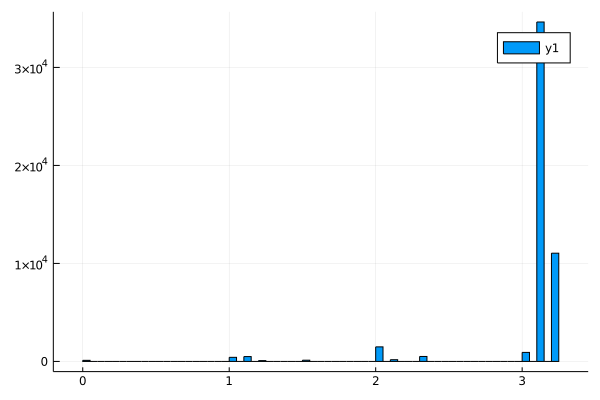

In [49]:
histogram(resampled["Type"])

In [147]:
#% Guide to types:% 1: Sedimentary%   1.1: Alluvium%   
# 1.2: Sandstone, Siltstone, unspecified Siliciclastic%   
# 1.3: Shale   1.4: Carbonate   1.5: Chert   1.6: Evaporite  
# 1.7: Phosphorite   1.8: Coal   1.9: Volcaniclastic 2: Metamorphic 
# 2.1: Metasedimentary   2.3: Metaigneous 3: Igneous  3.1: Volcanic  
# 3.2: Plutonic

# Carbonates are result of chemical weathering -- so still from weathered ign 
# If: hydrothermal alteration doesn't change anything AND subducted sed = ave sed 
# Check rare earth elts. should stay in clays (not chemical weather) -- propogate rare earth elts.

sed = (resampled["Type"] .>= 1) .& (resampled["Type"] .< 1.4);
ign = (resampled["Type"] .== 3.1) .| (resampled["Type"] .== 1.9); 
pluton = ((resampled["Type"] .== 3.2) .| (resampled["Type"] .== 2.3)) .& (resampled["SiO2"] .> 50);

In [107]:
uc = elementify(readdlm("../data/test/cracks_and_spheres/results-upper.csv", ','));

In [148]:
sed_mean = nanmean(resampled["SiO2"][sed])
vol_mean = nanmean(resampled["SiO2"][ign])
pluton_mean = nanmean(resampled["SiO2"][pluton])
uc_mean = nanmean(uc["SiO2"]);

println("SiO2 in seds, volcanics, plutons, upper crust = $sed_mean, $vol_mean, $pluton_mean, $uc_mean")

SiO2 in seds, volcanics, plutons, upper crust = 57.29549507969835, 53.07960190370025, 62.412509406037415, 63.74187897088693


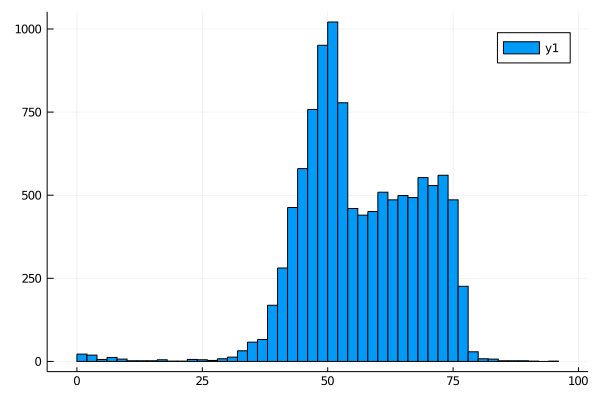

In [151]:
histogram(resampled["SiO2"][resampled["Type"] .== 3.2])

In [109]:
# Mixing ratio: m*ign + (1-m)*uc = sed
m = (sed_mean - uc_mean)/(vol_mean - uc_mean)

0.6045972966719676

In [110]:
# Mixing ratio if we used average pluton instead of inverted upper crust 
m_pluton = (sed_mean - pluton_mean)/(vol_mean - pluton_mean)

0.5482765499451971

In [140]:
chondrite = [367, 957, 137, 711, 231, 87, 306, 58, 381, 85.1, 249, 35.6, 248, 38.1] 
chondrite = chondrite ./ sum(chondrite)

1.0000000000000002

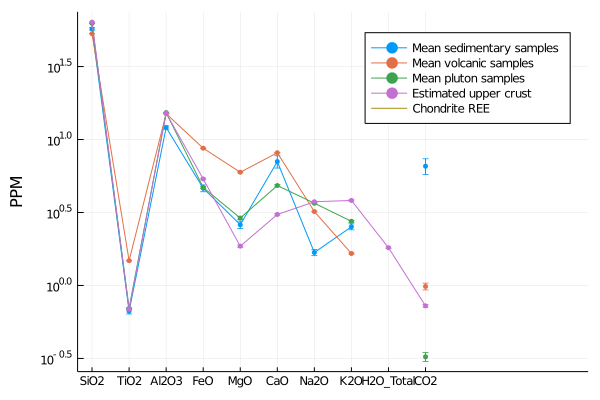

In [158]:
sed_ree = [nanmean(resampled[e][sed]) for e in COMPOSITION_ELEMENTS]
vol_ree = [nanmean(resampled[e][ign]) for e in COMPOSITION_ELEMENTS]
pluton_ree = [nanmean(resampled[e][pluton]) for e in COMPOSITION_ELEMENTS]
uc_ree = [nanmean(uc[e]) for e in COMPOSITION_ELEMENTS]

chondrite_ree = chondrite .* sum([sum([sed_ree[e], vol_ree[e], pluton_ree[e], uc_ree[e]])/4 for e in 1:length(COMPOSITION_ELEMENTS)])

oversampling_ratio_bulk = sum(good)/length(resampled["SiO2"])
# oversampling_ratio_uc = ????????????????

sed_sem = [nanstd(resampled[e][sed])*
    sqrt(oversampling_ratio_bulk/
        (sum(.~ isnan.(resampled[e][sed])))) for e in COMPOSITION_ELEMENTS]

vol_sem = [nanstd(resampled[e][ign])*
    sqrt(oversampling_ratio_bulk/
        (sum(.~ isnan.(resampled[e][ign])))) for e in COMPOSITION_ELEMENTS]

plu_sem = [nanstd(resampled[e][pluton])*
    sqrt(oversampling_ratio_bulk/
        (sum(.~ isnan.(resampled[e][pluton])))) for e in COMPOSITION_ELEMENTS]

uc_sem = [nanstd(uc[e])/sqrt(sum(.~ isnan.(uc[e]))) for e in COMPOSITION_ELEMENTS] ## TODO oversampling ratio?

plot(sed_ree, yerr=sed_sem, label="Mean sedimentary samples", marker=true, markerstrokecolor=:auto, markersize=3, 
    xticks=(1:length(COMPOSITION_ELEMENTS), COMPOSITION_ELEMENTS))
plot!(vol_ree, yerr=vol_sem, label="Mean volcanic samples", marker=true, markerstrokecolor=:auto, markersize=3)
plot!(pluton_ree, yerr=plu_sem, label="Mean pluton samples", marker=true, markerstrokecolor=:auto, markersize=3)
plot!(uc_ree, yerr=uc_sem, label="Estimated upper crust", marker=true, markerstrokecolor=:auto, markersize=3)
plot!(chondrite_ree, label="Chondrite REE")
plot!(ylabel="PPM", yaxis=:log)

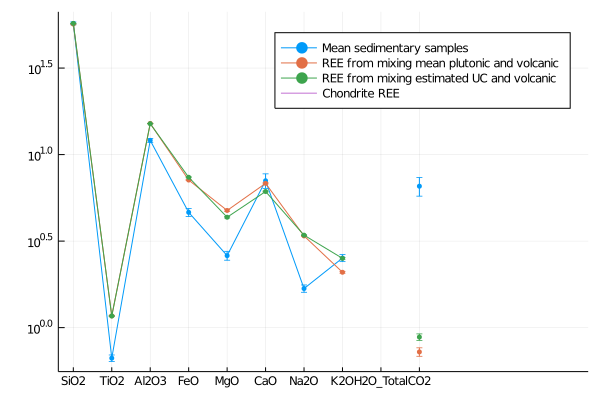

In [161]:
mixed_uc_ree = [m*vol_ree[i]+(1-m)*uc_ree[i] for i in 1:length(COMPOSITION_ELEMENTS)]
mixed_pluton_ree = [m*vol_ree[i]+(1-m)*pluton_ree[i] for i in 1:length(COMPOSITION_ELEMENTS)]

mixed_uc_sem = [m*vol_sem[i]+(1-m)*uc_sem[i] for i in 1:length(COMPOSITION_ELEMENTS)]
mixed_pluton_sem = [m*vol_sem[i]+(1-m)*plu_sem[i] for i in 1:length(COMPOSITION_ELEMENTS)]

plot(sed_ree, yerr=sed_sem, label="Mean sedimentary samples", marker=true, markerstrokecolor=:auto, markersize=3, 
    xticks=(1:length(COMPOSITION_ELEMENTS), COMPOSITION_ELEMENTS))
plot!(mixed_pluton_ree, yerr=mixed_pluton_sem, marker=true, markerstrokecolor=:auto, markersize=3,
    label="REE from mixing mean plutonic and volcanic")
plot!(mixed_uc_ree, yerr=mixed_uc_sem, marker=true, markerstrokecolor=:auto, markersize=3,
    label="REE from mixing estimated UC and volcanic")
plot!(chondrite_ree, label="Chondrite REE")
plot!(yaxis=:log)

In [116]:
for e in REE
    println("for $e, $(sum(.~ isnan.(uc[e])))")
end

for La, 2436
for Ce, 2405
for Pr, 851
for Nd, 2223
for Sm, 2121
for Eu, 2001
for Gd, 1680
for Tb, 1649
for Dy, 1066
for Ho, 906
for Er, 1045
for Tm, 836
for Yb, 2044
for Lu, 1845


In [137]:
println(keys(bulk))

["Pb206_Pb208", "Pd", "MgO", "Ag", "Gd", "Pb208_Pb206", "Th230_Activity", "Cl36_Cl", "Ra228_Ra226_Activity", "Cs", "Xe136_Xe130", "Ta", "Te", "Xe136_Xe132", "Al2O3", "Loi", "Fe2O3", "Ra228_Th232_Activity", "K", "Kr78_Kr84", "Re187_Os188", "BurwellAge", "Mo", "BurwellType", "U238", "CoO", "Th232_Pb204", "Sc", "AgeAve", "Age_Min", "Fe2O3T", "Er", "F", "Ra226_Th230_Activity", "Dy", "Latitude", "err2srel", "CaO", "Delta_C13", "Hf", "In", "Xe124_Xe132", "tc1Lith", "Ar40_Ar36", "Ba", "Nd", "Ra226", "Zr", "H2O", "Pa231", "Cr", "Cu", "tc1Crust", "Lu", "Na", "Age_Max", "Pb206_Pb204", "Co", "Sn", "Xe130_Xe132", "Pb", "MnO", "Ger", "Xe126_Xe130", "TiO2", "AgeEst_Min", "Os186_Os188", "Ga", "CO2", "Y", "U", "FeO", "BurwellAge_Min", "U234_U238", "AgeEst", "Pr", "Th", "Be10_Be", "Ar40_Ar39", "Al", "Th230_Th232", "La", "W", "Ar38_Ar36", "B", "NiO", "K40_Ar36", "Ne21_Ne20", "Cl", "SiO2", "Rb", "Sr87_Sr86", "H2O_Total", "Rb87_Sr86", "Th230_Th232_Activity", "SO2", "Xe128_Xe130", "Hg", "Yb", "Eu", "He4_Ne